<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_overfitting_scikitlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# NEW!
from sklearn.model_selection import train_test_split

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

In [3]:
# create our fake dataset

fakedata = np.tile(np.array([1, 2, 3, 4]), (10, 1)) + np.tile(10*np.arange(1, 11), (4, 1)).T
fakelabels = np.arange(10) > 4
print(fakedata), print(' ')
print(fakelabels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
 
[False False False False False  True  True  True  True  True]


In [5]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(fakedata, fakelabels,test_size=.2)

# print out the sizes
print('Training data size: ' + str(train_data.shape))
print('Test data size: ' + str(test_data.shape))
print(' ')

# print out  the train/test data
print('Training data: ')
print(train_data)
print(' ')

print('Test data: ')
print(test_data)

Training data size: (8, 4)
Test data size: (2, 4)
 
Training data: 
[[101 102 103 104]
 [ 21  22  23  24]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [ 51  52  53  54]
 [ 41  42  43  44]
 [ 61  62  63  64]
 [ 11  12  13  14]]
 
Test data: 
[[71 72 73 74]
 [31 32 33 34]]


In [19]:
# create the ANN model
def createANewModel():
    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4, 64),   # input layer
        nn.ReLU(),          # activation unit
        nn.Linear(64, 64),  # hidden layer
        nn.ReLU(),          # activation unit
        nn.Linear(64, 3)    # output layer
    )

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.01)
    
    return ANNiris, lossfun, optimizer
    
ANNiris, lossfun, optimizer = createANewModel()

In [20]:
# train the model

# global parameter
numepochs = 200

def trainTheModel(trainProp):

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=trainProp)

    # loop over epochs
    for epochi in range(numepochs):

        # separate train from test data
        # Note 1: unique split for each epcoh!
        # Note 2: here we specify the training size, not the test size


        # forward pass and loss
        yHat = ANNiris(X_train)
        loss = lossfun(yHat, y_train)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # compute training accuracy
        trainAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y_train).float()).item())

        # test accuracy
        predlabels = torch.argmax(ANNiris(X_test), axis=1)
        testAcc.append(100 * torch.mean((predlabels == y_test).float()).item())

    # function output
    return trainAcc, testAcc

In [21]:
# train the model
trainAcc, testAcc = trainTheModel(.8)

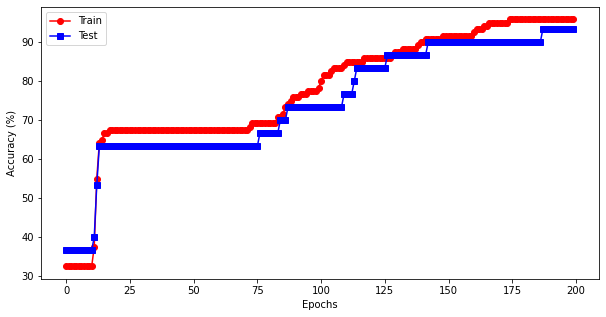

In [22]:
fig = plt.figure(figsize=(10, 5))

plt.plot(trainAcc, 'ro-')
plt.plot(testAcc, 'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.show()

# Now for the experiment

In [36]:
trainSetSizes = np.linspace(.2, .95, 10)

allTrainAcc = np.zeros((len(trainSetSizes), numepochs))
allTestAcc = np.zeros((len(trainSetSizes), numepochs))

for i in range(len(trainSetSizes)):

    # create a model
    ANNiris, lossfun, optimizer = createANewModel()

    # train the model
    trainAcc, testAcc = trainTheModel(trainSetSizes[i])


    # store the results
    allTrainAcc[i, :] = trainAcc
    allTestAcc[i, :] = testAcc

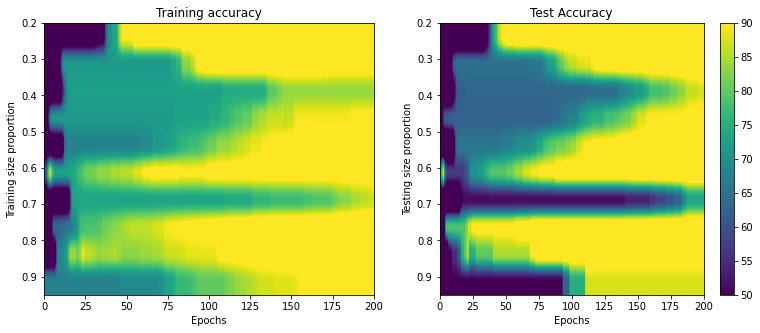

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].imshow(allTrainAcc, aspect='auto',
             vmin=50, vmax=90, extent=[0, numepochs, trainSetSizes[-1], trainSetSizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(allTestAcc, aspect='auto', vmin=50, vmax=90, extent=[0, numepochs, trainSetSizes[-1], trainSetSizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Testing size proportion')
ax[1].set_title('Test Accuracy')
fig.colorbar(p, ax=ax[1])

plt.show()
